# Exploratory Data Analysis

Let's play!

In [1]:
# Install additional packages
!python -m pip install seaborn
!python -m pip install xgboost
!python -m pip install m2cgen
!python -m pip install treelite
!python -m pip install treelite_runtime
!python -m pip install tl2cgen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.8/922.8 kB 3.0 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.8/774.8 kB 3.0 MB/s eta 0:00:00-:--:--


In [2]:
import os

import keras
import matplotlib.pyplot as plt
import m2cgen as m2c
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import treelite
import treelite_runtime
import tl2cgen
from xgboost import XGBClassifier, XGBRegressor

In [81]:
# Settings
DATA_PATH = "data/p1s"
SEED = 42
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2
MAX_POT = 3.3
MODEL_PATH = "models/p1s"
SERVO_STATE_FREE = 0
SERVO_STATE_CONTACT = 1
SERVO_STATE_STALL = 2
FORCE_THRESHOLD = 5000      # Used to piecewise normalize force data (mN)
FORCE_THRESHOLD_NORM = 0.5  # Normalized force threshold
NO_FORCE_DIR = "0mm"        # Directory for data with no force applied

# Define data sets to keep
rot_keep = ["0_deg", "45_deg", "90_deg", "135_deg", "180_deg"]
dist_keep = ["0mm", "100mm", "120mm"]
volt_keep = ["6_0V"]

In [112]:
# Set default devcice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Shuffle and Split Data Files

In [98]:
# Create a list of file paths for the data
def get_file_paths(rot_keep, dist_keep, volt_keep):
    file_paths = []
    for rot_dir in os.listdir(DATA_PATH):
        if rot_dir not in rot_keep:
            continue
        for dist_dir in os.listdir(os.path.join(DATA_PATH, rot_dir)):
            if dist_dir not in dist_keep:
                continue
            for volt_dir in os.listdir(os.path.join(DATA_PATH, rot_dir, dist_dir)):
                if volt_dir not in volt_keep:
                    continue
                for file_name in os.listdir(os.path.join(DATA_PATH, rot_dir, dist_dir, volt_dir)):
                    file_paths.append(os.path.join(DATA_PATH, rot_dir, dist_dir, volt_dir, file_name))

    return file_paths

In [99]:
# Get files in the data directory
csv_files = get_file_paths(rot_keep, dist_keep, volt_keep)

# Shuffle list of files
rng = np.random.default_rng(seed=SEED)
rng.shuffle(csv_files)

# Split files into train, validation, and test sets
num_files = len(csv_files)
num_val_files = int(num_files * VAL_SPLIT)
num_test_files = int(num_files * TEST_SPLIT)
val_files = csv_files[:num_val_files]
test_files = csv_files[num_val_files:num_val_files + num_test_files]
train_files = csv_files[num_val_files + num_test_files:]

# Print split information
print(f"Total files: {num_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Total files: 1560
Train files: 936
Validation files: 312
Test files: 312


## Initial Exploration (Correlation)

In [6]:
# Load data
def load_csv_files(files):
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(file))
    return pd.concat(df_list, ignore_index=True)

# Build dataframes
df_train = load_csv_files(train_files)
df_val = load_csv_files(val_files)
df_test = load_csv_files(test_files)

# Remove leading and trailing whitespaces from column names
df_train.columns = df_train.columns.str.strip()
df_val.columns = df_val.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Get columns from dataframe
columns = df_train.columns
print(columns)

Index(['Timestamp', 'Desired Position', 'Servo Current', 'Servo Voltage',
       'Servo Potentiometer', 'Encoder', 'Force'],
      dtype='object')


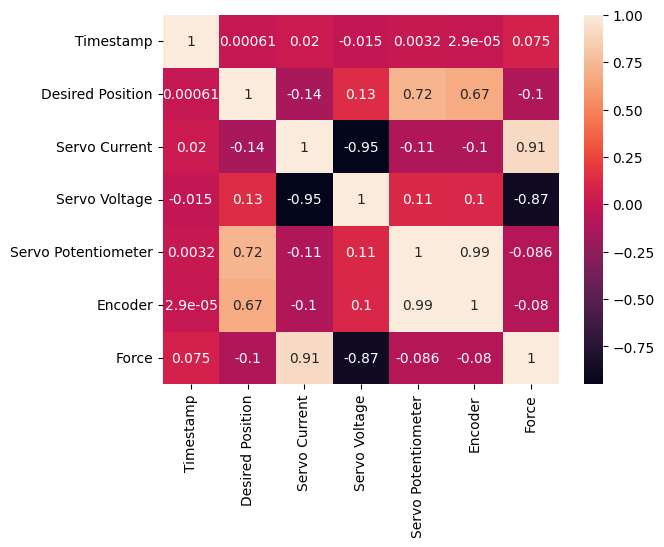

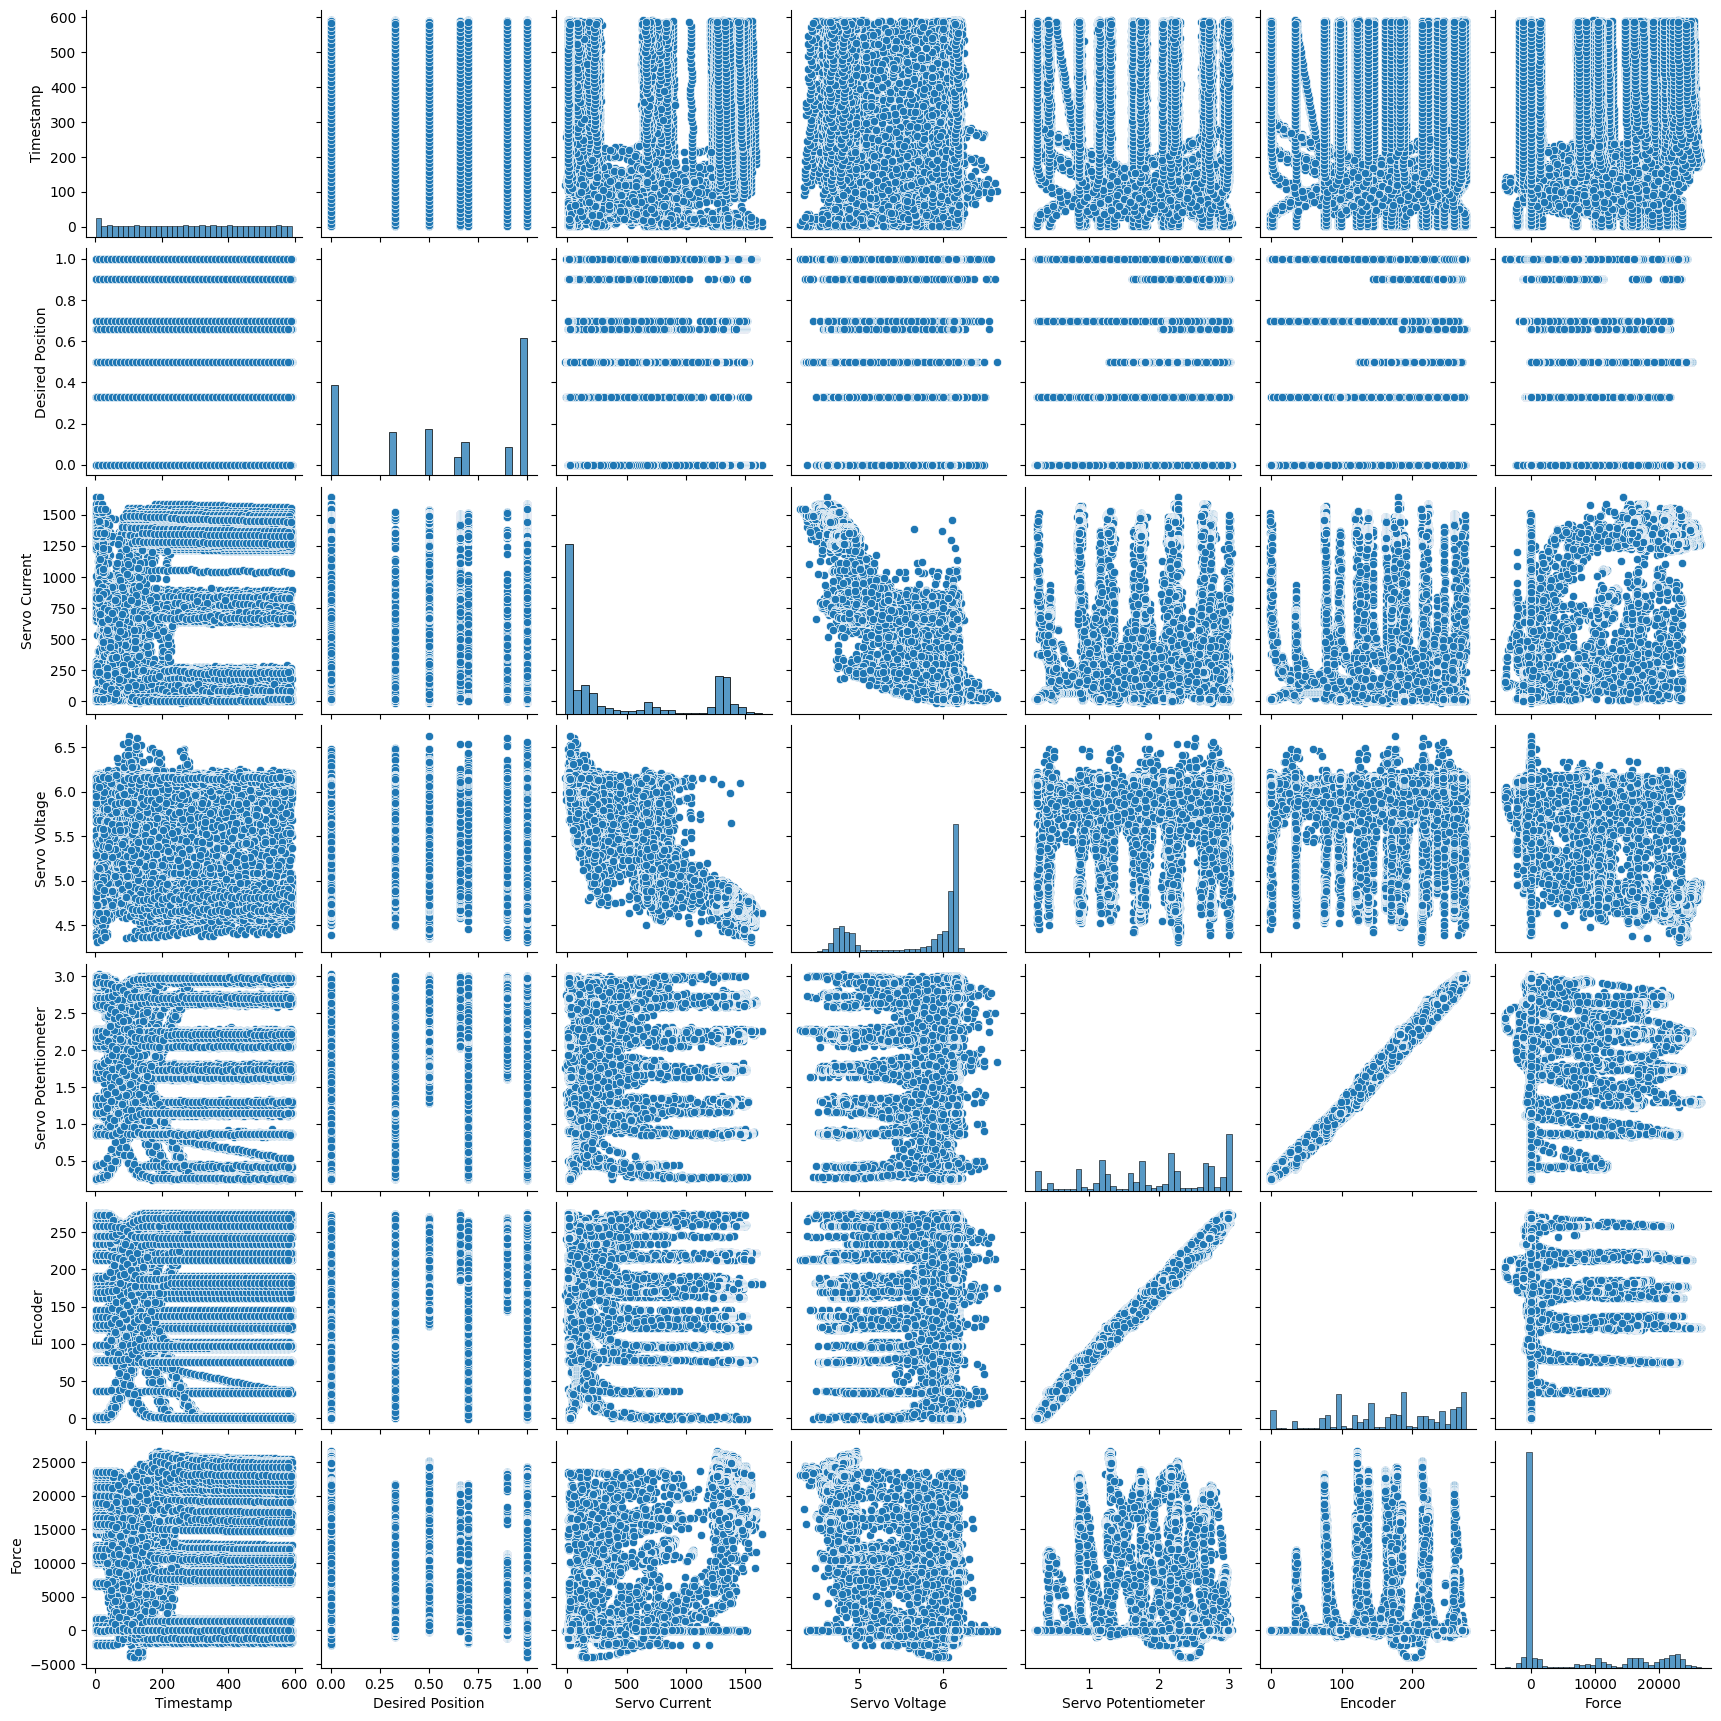

In [7]:
# Create correlation plots
sns.heatmap(df_train[columns].corr(), annot=True)
sns.pairplot(df_train[columns])

In [8]:
# Clone dataframes
df_pos_train = df_train.copy()
df_pos_val = df_val.copy()
df_pos_test = df_test.copy()

# Create a column that is delta timestamp
df_pos_train['delta_time'] = df_train['Timestamp'].diff()
df_pos_val['delta_time'] = df_val['Timestamp'].diff()
df_pos_test['delta_time'] = df_test['Timestamp'].diff()

# Drop rows with NaN values
df_pos_train.dropna(inplace=True)
df_pos_val.dropna(inplace=True)
df_pos_test.dropna(inplace=True)

# Drop timestamp, desired position, and servo voltage columns
df_pos_train.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_val.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_test.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)

# Get new columns from dataframe
columns = df_pos_train.columns
print(columns)

Index(['Servo Current', 'Servo Potentiometer', 'Encoder', 'Force',
       'delta_time'],
      dtype='object')


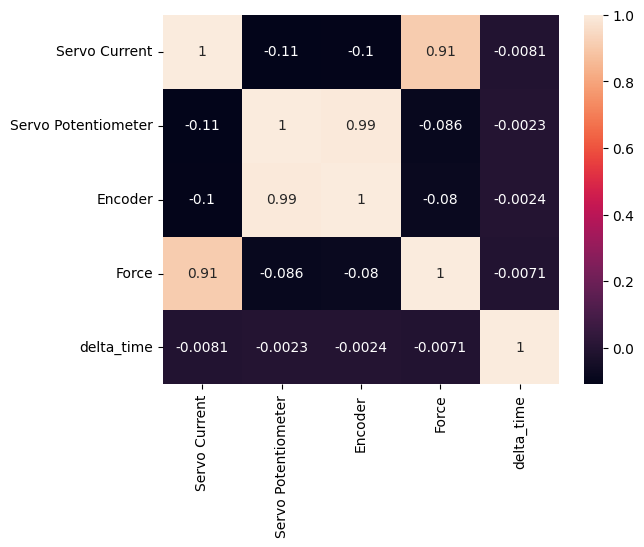

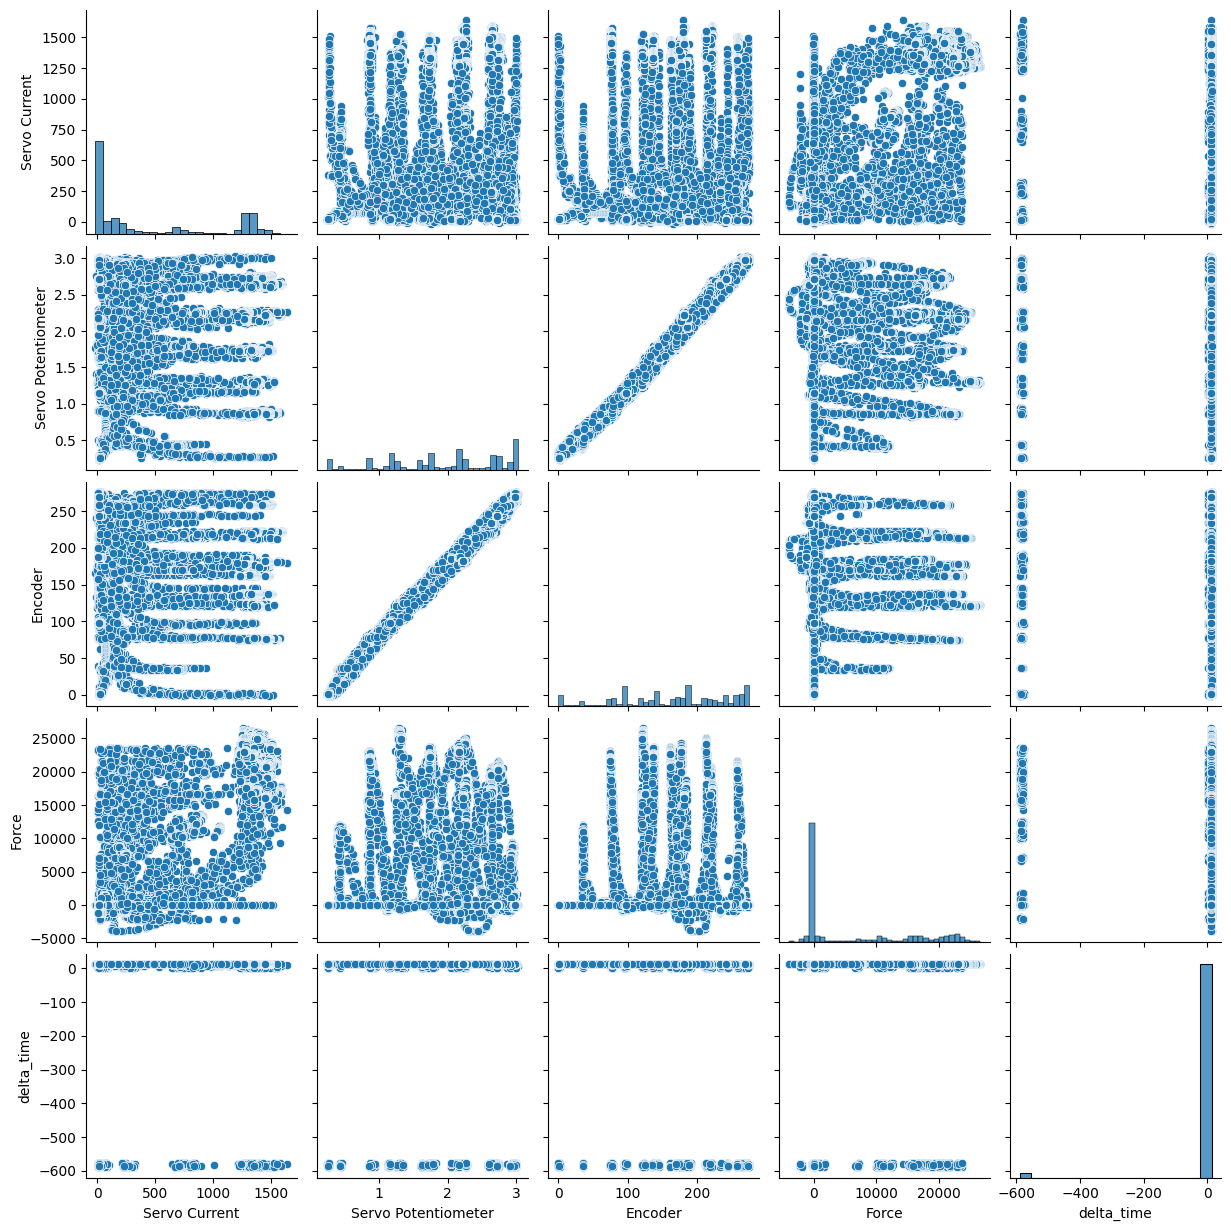

In [9]:
# Create correlation plots
sns.heatmap(df_pos_train[columns].corr(), annot=True)
sns.pairplot(df_pos_train[columns])


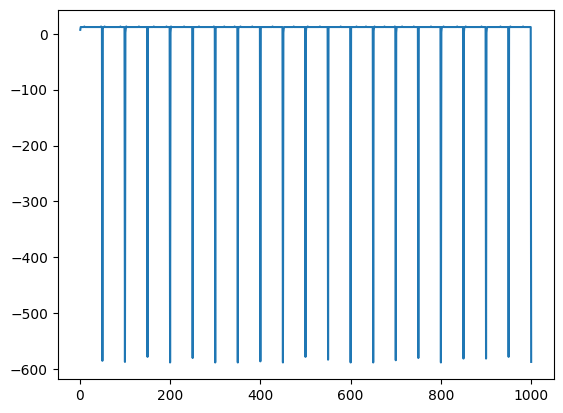

In [10]:
# Plot delta time over time (heads up: includes space between files)
plt.plot(df_pos_train['delta_time'][0:1000])

## Try Linear Regression Model for Position Estimation

In [11]:
# Train model
X_train = df_train[['Servo Potentiometer']]
y_train = df_train['Encoder']
model = LinearRegression()
model.fit(X_train, y_train)

# Validate model
X_val = df_val[['Servo Potentiometer']]
y_val = df_val['Encoder']
y_val_pred = model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean squared error (val): {mse}")

Mean squared error (val): 82.90473743571285


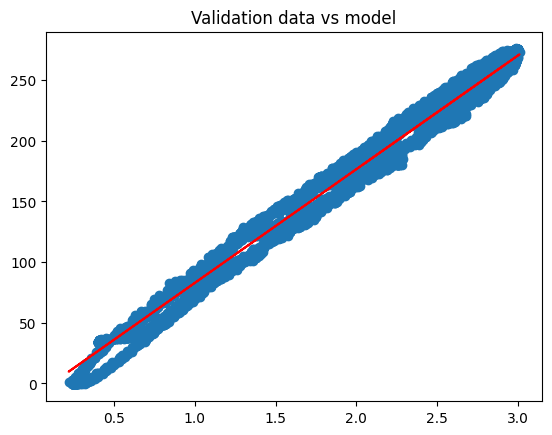

In [12]:
# Plot line vs actual values
plt.scatter(X_val, y_val)
plt.plot(X_val, y_val_pred, color='red')
plt.title('Validation data vs model')
plt.show()

## Stall Estimation Exploration

In [13]:
# Plot positional differences
def plot_similar_set(title, file_paths, fn):
    
    # List of position differences
    dpos_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()

        # Call arbitrary function passed in
        dpos = fn(df)
        dpos_list.append(dpos)

    # Plot position differences with legend
    for dpos in dpos_list:
        plt.plot(dpos)
    # plt.legend([os.path.basename(file_path) for file_path in file_paths])

    # Set plot title
    plt.title(title)

In [14]:
# Get file paths of similar tests (same angle traveled)
def get_file_paths_of_similar_tests(sample_set, test_prefix):
    file_paths = []
    for sample in sample_set:
        if os.path.basename(sample).startswith(test_prefix):
            file_paths.append(sample)

    return file_paths

In [15]:
num_files_per_set = 20

# Get similar sample set and shuffle
similar_set_01 = get_file_paths_of_similar_tests(train_files, "0.0_0.333")[:num_files_per_set]
similar_set_02 = get_file_paths_of_similar_tests(train_files, "0.0_1.0")[:num_files_per_set]
similar_set_03 = get_file_paths_of_similar_tests(train_files, "0.333_0.0")[:num_files_per_set]
similar_set_04 = get_file_paths_of_similar_tests(train_files, "0.333_1.0")[:num_files_per_set]
similar_set_05 = get_file_paths_of_similar_tests(train_files, "1.0_0.0")[:num_files_per_set]
similar_set_06 = get_file_paths_of_similar_tests(train_files, "1.0_0.333")[:num_files_per_set]

# Construct list of lists
similar_sets = [
    similar_set_01, 
    similar_set_02, 
    similar_set_03, 
    similar_set_04, 
    similar_set_05, 
    similar_set_06
]

# Make sure we have the correct number of files
for similar_set in similar_sets:
    print(len(similar_set))

20
20
20
20
20
20


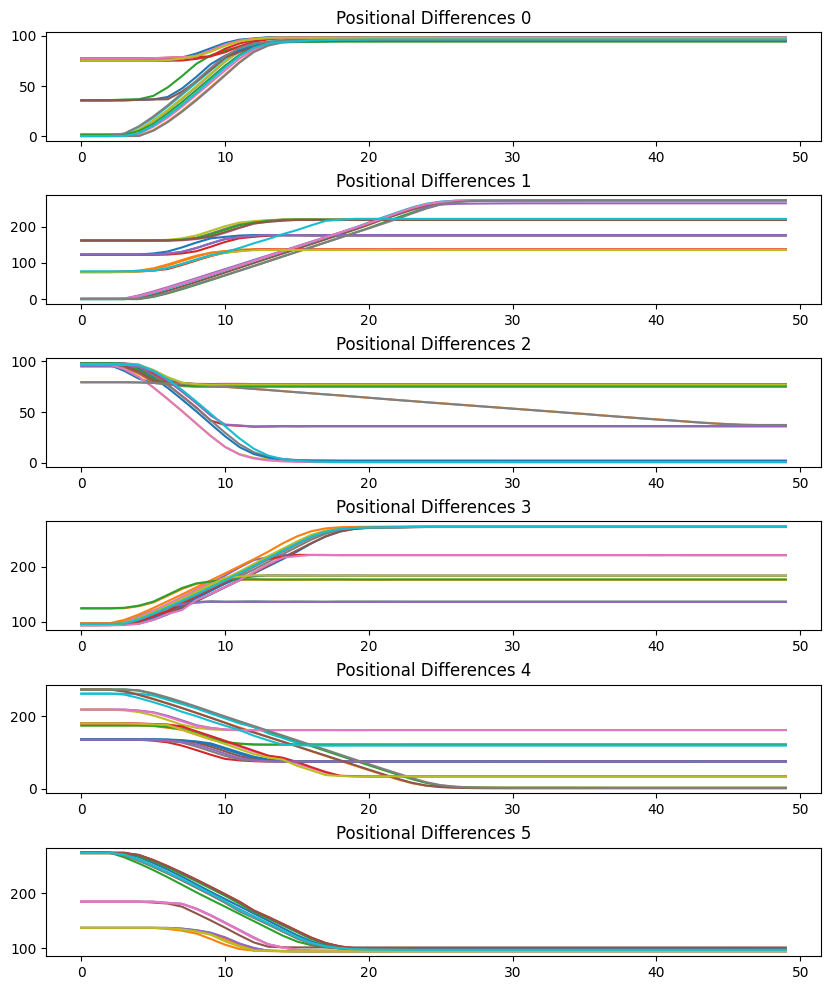

In [16]:
# Plot positional differences on subplots
fig, axs = plt.subplots(len(similar_sets), 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
for i, file_list in enumerate(similar_sets):
    plt.sca(axs[i])
    fn = lambda df: abs(df['Desired Position'] - df['Encoder'])
    plot_similar_set(f"Positional Differences {i}", file_list, fn)

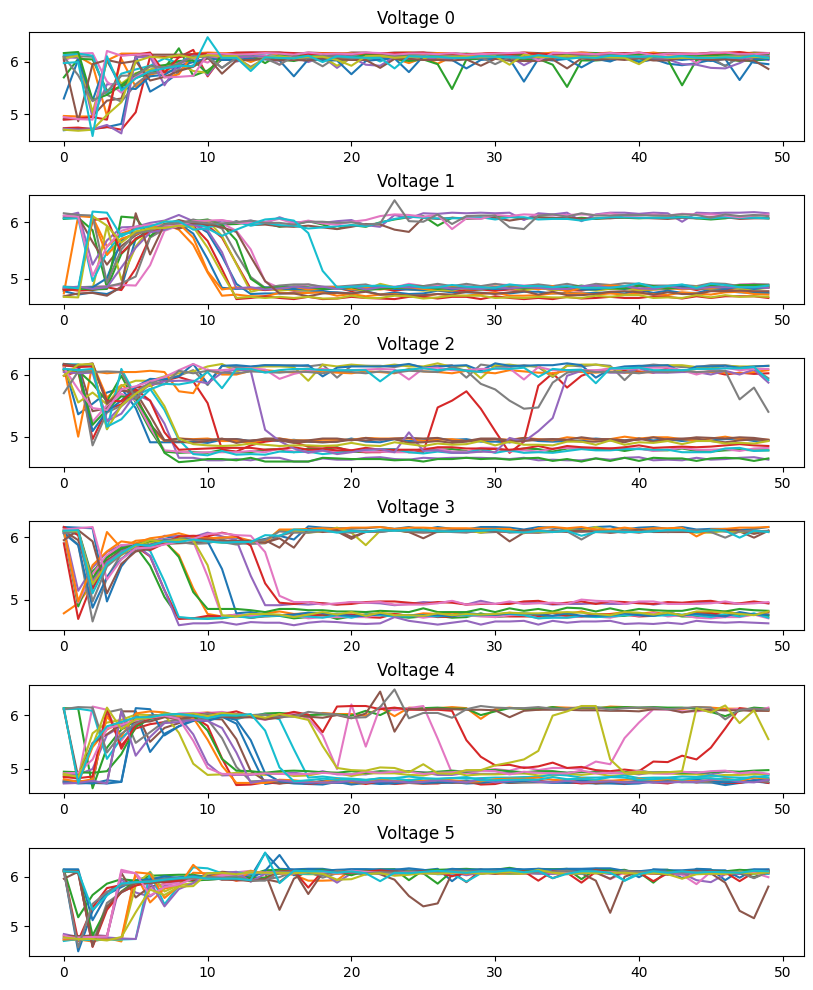

In [17]:
# Plot voltage on subplots
fig, axs = plt.subplots(len(similar_sets), 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
for i, file_list in enumerate(similar_sets):
    plt.sca(axs[i])
    fn = lambda df: df['Servo Voltage']
    plot_similar_set(f"Voltage {i}", file_list, fn)

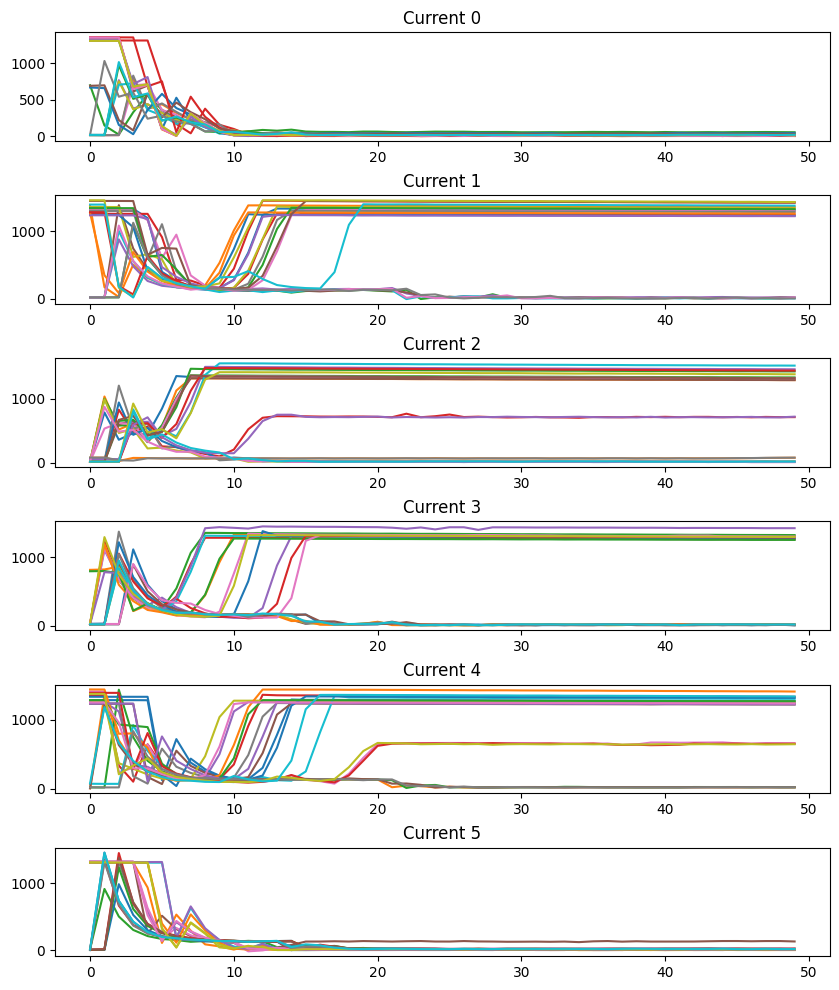

In [18]:
# Plot current on subplots
fig, axs = plt.subplots(len(similar_sets), 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
for i, file_list in enumerate(similar_sets):
    plt.sca(axs[i])
    fn = lambda df: df['Servo Current']
    plot_similar_set(f"Current {i}", file_list, fn)

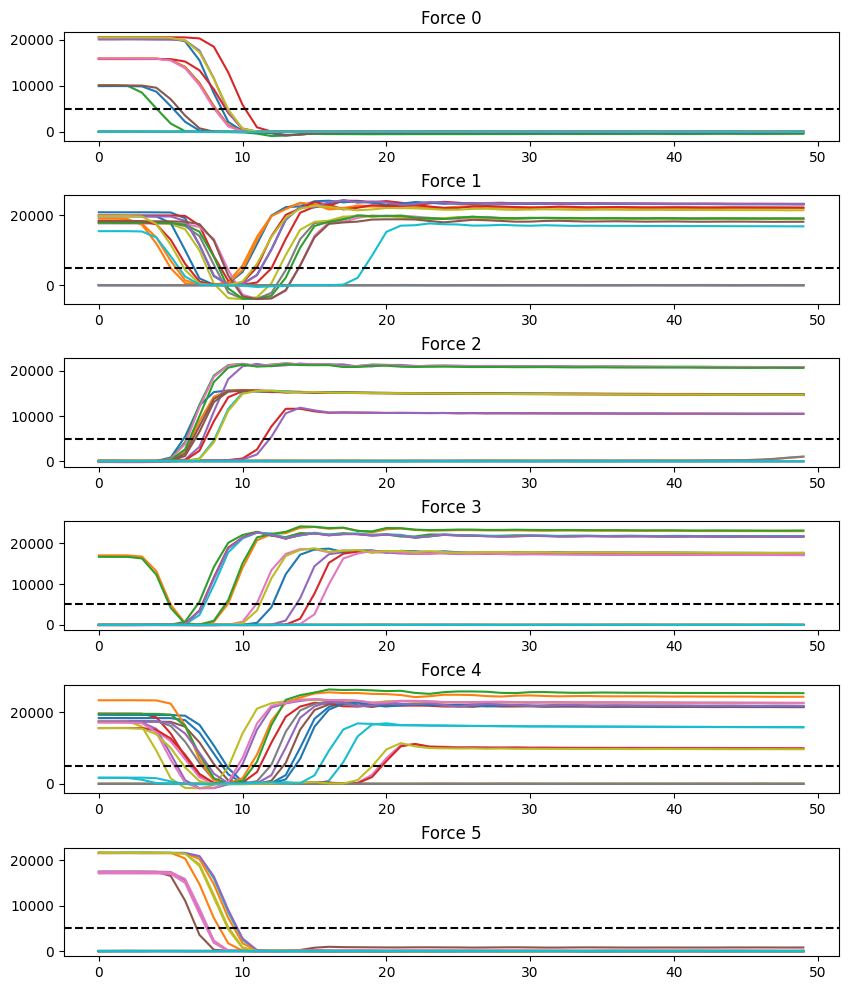

In [29]:
# Plot force on subplots and plot horizontal threshold line at 8000
fig, axs = plt.subplots(len(similar_sets), 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
for i, file_list in enumerate(similar_sets):
    plt.sca(axs[i])
    fn = lambda df: df['Force']
    plot_similar_set(f"Force {i}", file_list, fn)
    plt.axhline(y=FORCE_THRESHOLD, color='black', linestyle='dashed')

In [42]:
# Normalize
def normalize(val):
    return (val - val.min()) / (val.max() - val.min())

In [71]:
# Piecewise normalize force data
def piecewise_normalize_force(force):

    # Anything below zero is set to zero
    force[force < 0] = 0
    
    # Find indices where force is greater than threshold and group them
    idx_groups = np.where(force > FORCE_THRESHOLD)[0]
    idx_groups = np.split(idx_groups, np.where(np.diff(idx_groups) != 1)[0] + 1)

    # Get indices where force is less than threshold
    idx_below_threshold = np.where(force <= FORCE_THRESHOLD)[0]

    # Go through each group of indices
    for idx_group in idx_groups:
        if len(idx_group) > 0:
            
            # Normalize force in group where threshold becomes the minimum
            force[idx_group] = ((1 - FORCE_THRESHOLD_NORM) * 
                normalize(force[idx_group])) + FORCE_THRESHOLD_NORM

    # Normalize force to threshold outside of groups
    force[idx_below_threshold] = FORCE_THRESHOLD_NORM * normalize(force[idx_below_threshold])

    return force

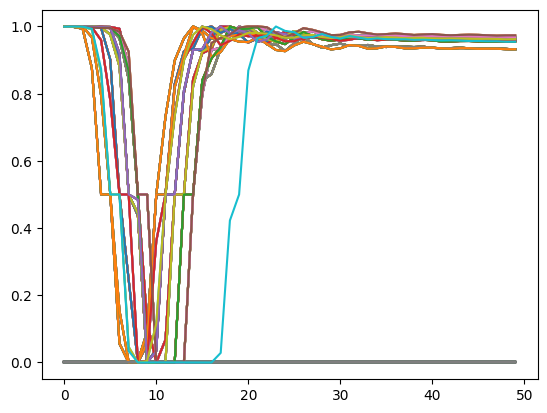

In [82]:
# Test piecewise normalization
file_paths = similar_sets[1]

# List of forces
force_list = []

# Read in data from files
for file_path in file_paths:

    # Read force column
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    force = df['Force']

    # If test is 0mm, set force to zero
    if NO_FORCE_DIR in file_path.split(os.path.sep):
        force = np.zeros(len(force))

    # Otherwise, piecewise normalize force
    else:
        force = piecewise_normalize_force(force)

    # Append force to list
    force_list.append(force)

    # Print forces
    for force in force_list:
        plt.plot(force)


In [83]:
# Plot piecewise normalized force
def plot_piecewise_normalized_force(file_paths, print_legend=False):
    
    # List of forces
    force_list = []

    # Read in data from files
    for file_path in file_paths:

        # Read force column
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        force = df['Force']

        # If test is 0mm, set force to zero
        if NO_FORCE_DIR in file_path.split(os.path.sep):
            force = np.zeros(len(force))

        # Otherwise, piecewise normalize force
        else:
            force = piecewise_normalize_force(force)

        # Append force to list
        force_list.append(force)

    # Print forces
    for force in force_list:
        plt.plot(force)

    # Optionally print legend(s)
    if print_legend:
        plt.legend(file_paths)

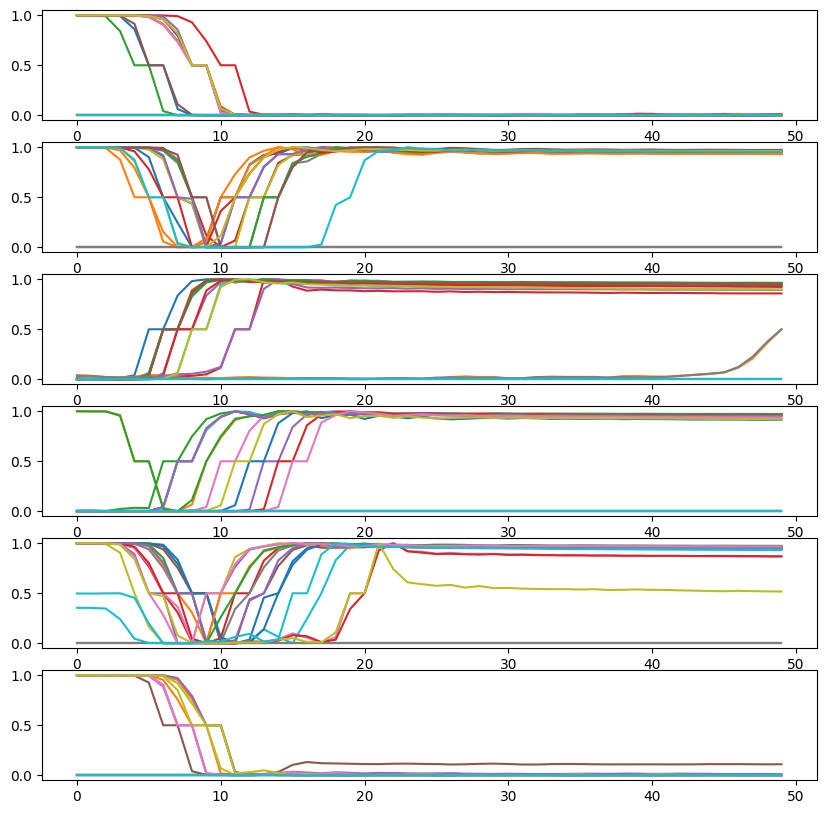

In [84]:
# Plot normalized force on subplots
fig, axs = plt.subplots(len(similar_sets), 1, figsize=(10, 10))
for i, file_list in enumerate(similar_sets):
    plt.sca(axs[i])
    if i in []:
        print_legend = True
    else:
        print_legend = False
    plot_piecewise_normalized_force(file_list, print_legend)

## Create Dataset

In [100]:
# Load data and modify dataframes
def load_and_modify_data(files):

    # Create list of dataframes from CSV files
    df_list = []
    for file in files:

        # Read CSV file and strip column names
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()

        # "Stall" is the piecewise normalized force
        stall = df['Force']
        if NO_FORCE_DIR in file.split(os.path.sep):
            stall = np.zeros(len(stall))
        else:
            stall = piecewise_normalize_force(stall)
        df['Stall'] = stall

        # Create a categorized servo state based on the stall value
        state_conditions = [
            df['Stall'] <= 0.1,
            (df['Stall'] > 0.1) & (df['Stall'] <= 0.8),
            df['Stall'] > 0.8
        ]
        state_choices = [SERVO_STATE_FREE, SERVO_STATE_CONTACT, SERVO_STATE_STALL]
        df['Servo State'] = np.select(state_conditions, state_choices)
        
        # Creata a "delta time" column (seconds)
        df['Delta Time'] = df['Timestamp'].diff() / 1000

        # Create a "current derivative" column
        df['Derivative Current'] = df['Servo Current'].diff() / df['Delta Time']

        # Normalize the potentiometer readings
        df['Norm Potentiometer'] = df['Servo Potentiometer'] / MAX_POT

        # Create a "position derivative" column
        df['Derivative Potentiometer'] = df['Norm Potentiometer'].diff() / df['Delta Time']

        # Create sin and cos columns (1.0 = 180 degrees)
        df['Sin Potentiometer'] = np.sin(df['Norm Potentiometer'] * np.pi)
        df['Cos Potentiometer'] = np.cos(df['Norm Potentiometer'] * np.pi)

        # Create multiplication columns
        df['Current * Potentiometer'] = df['Servo Current'] * df['Norm Potentiometer']

        # Clean up the dataframe (drop NaN values and columns)
        df.dropna(inplace=True)

        # Drop columns
        df.drop(columns=[
            'Timestamp', 
            'Servo Voltage', 
            'Encoder', 
            'Force', 
            'Servo Potentiometer'
        ], inplace=True)
        
        # Append dataframe to list
        df_list.append(df)

    return pd.concat(df_list, ignore_index=True)

In [101]:
# Build dataframes
df_train = load_and_modify_data(train_files)
df_val = load_and_modify_data(val_files)
df_test = load_and_modify_data(test_files)

# Get column names from dataframe
columns = df_train.columns
print(columns)

Index(['Desired Position', 'Servo Current', 'Stall', 'Servo State',
       'Delta Time', 'Derivative Current', 'Norm Potentiometer',
       'Derivative Potentiometer', 'Sin Potentiometer', 'Cos Potentiometer',
       'Current * Potentiometer'],
      dtype='object')


## Model Exploration (Time Windowing)

In [181]:
# Readings per sample (window depth)
READINGS_PER_SAMPLE = 1

In [182]:
# Create windowed dataframes
def create_windowed_data(df, readings_per_sample):

    # Create a list of dataframes
    df_list = []

    # Create a windowed dataframe
    for i in range(len(df) - readings_per_sample):
        df_window = df[i:i + readings_per_sample].copy()
        df_window.reset_index(drop=True, inplace=True)
        df_list.append(df_window)

    return pd.concat(df_list, ignore_index=True)

In [183]:
# Create windowed dataframes
df_train_windowed = create_windowed_data(df_train, READINGS_PER_SAMPLE)
df_val_windowed = create_windowed_data(df_val, READINGS_PER_SAMPLE)
df_test_windowed = create_windowed_data(df_test, READINGS_PER_SAMPLE)

# Print length of windowed dataframes
print(len(df_train_windowed))

45670


In [184]:
df_train_windowed.head(20)

Desired Position  Servo Current     Stall  Servo State  Delta Time  \
0                0.7          879.2  0.999799            2       0.007   
1                0.7          873.6  0.999432            2       0.012   
2                0.7           19.3  0.999051            2       0.012   
3                0.7           87.7  0.991958            2       0.012   
4                0.7          242.5  0.913899            2       0.012   
5                0.7          611.8  0.736426            1       0.012   
6                0.7          289.1  0.500000            1       0.012   
7                0.7          108.2  0.500000            1       0.012   
8                0.7           17.3  0.000000            0       0.012   
9                0.7          121.1  0.000000            0       0.013   
10               0.7           58.0  0.000000            0       0.012   
11               0.7           41.1  0.000000            0       0.012   
12               0.7           36.4  0.000000            0       0.012   
13               0.7           34.2  0.000000            0       0.012   
14               0.7           41.2  0.000000            0       0.012   
15               0.7           32.6  0.000000            0       0.012   
16               0.7            4.8  0.000000            0       0.012   
17               0.7            4.8  0.000000            0       0.012   
18               0.7            4.8  0.000000            0       0.012   
19               0.7            4.9  0.000000            0       0.012   

    Derivative Current  Norm Potentiometer  Derivative Potentiometer  \
0        -64142.857143            0.781818                 -0.432900   
1          -466.666667            0.781818                  0.000000   
2        -71191.666667            0.781818                  0.000000   
3          5700.000000            0.772727                 -0.757576   
4         12900.000000            0.760606                 -1.010101   
5         30775.000000            0.739394                 -1.767677   
6        -26891.666667            0.721212                 -1.515152   
7        -15075.000000            0.687879                 -2.777778   
8         -7575.000000            0.669697                 -1.515152   
9          7984.615385            0.663636                 -0.466200   
10        -5258.333333            0.654545                 -0.757576   
11        -1408.333333            0.654545                  0.000000   
12         -391.666667            0.651515                 -0.252525   
13         -183.333333            0.651515                  0.000000   
14          583.333333            0.654545                  0.252525   
15         -716.666667            0.651515                 -0.252525   
16        -2316.666667            0.657576                  0.505051   
17            0.000000            0.654545                 -0.252525   
18            0.000000            0.654545                  0.000000   
19            8.333333            0.654545                  0.000000   

    Sin Potentiometer  Cos Potentiometer  Current * Potentiometer  
0            0.633012          -0.774142               687.374545  
1            0.633012          -0.774142               682.996364  
2            0.633012          -0.774142                15.089091  
3            0.654861          -0.755750                67.768182  
4            0.683158          -0.730271               184.446970  
5            0.730271          -0.683158               452.361212  
6            0.768080          -0.640353               208.502424  
7            0.830808          -0.556559                74.428485  
8            0.861226          -0.508222                11.585758  
9            0.870746          -0.491733                80.366364  
10           0.884433          -0.466667                37.963636  
11           0.884433          -0.466667                26.901818  
12           0.888835          -0.458227            

In [185]:
# Convert dataframes to 3D tensors and ground-truth tensors
def df_to_tensor(df, readings_per_sample, X_cols, y_cols):

    # Get number of samples
    num_samples = len(df) // readings_per_sample

    # y is the final reading in each sample
    y = df[y_cols].iloc[readings_per_sample - 1::readings_per_sample].values
    y = torch.tensor(y, dtype=torch.float32)

    # Create 3D tensor
    X = torch.zeros((num_samples, readings_per_sample, len(X_cols)))

    # Fill tensor (only with X columns)
    for i in range(num_samples):
        X[i] = torch.tensor(df[X_cols].iloc[(i * readings_per_sample):((i + 1) * readings_per_sample)].values, dtype=torch.float32)

    return X, y

## Classification

In [186]:
# Choose X and y columns
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    # 'Derivative Potentiometer',
    # 'Derivative Current',
    # 'Sin Potentiometer',
    # 'Cos Potentiometer',
    # 'Current * Potentiometer',
]
y_cols = ['Servo State']

# Convert dataframes to 3D tensors
X_train, y_train = df_to_tensor(df_train_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_val, y_val = df_to_tensor(df_val_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_test, y_test = df_to_tensor(df_test_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)

# Zip data
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))
test_data = list(zip(X_test, y_test))

# Shuffle data
rng.shuffle(train_data)
rng.shuffle(val_data)
rng.shuffle(test_data)

# Unzip data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to tensors
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)
X_val = torch.stack(X_val)
y_val = torch.stack(y_val)
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

# Show shape
print(X_train.shape)

torch.Size([45670, 1, 2])


In [187]:
# Make sure the tensor is correct (no longer matches dataframe after shuffle)
# i = 10507
# df_train_windowed.iloc[(i * READINGS_PER_SAMPLE):((i + 1) * READINGS_PER_SAMPLE)]

In [188]:
# print(X_train[i, :, :])
# print(y_train[i])

In [189]:
# Copy data to device (for training)
X_train_tensor = X_train.to(device)
y_train_tensor = y_train.to(device)
X_val_tensor = X_val.to(device)
y_val_tensor = y_val.to(device)

### Model Exploration: Random Forest (Windowed)

In [190]:
# Train random forest classifier
rf = RandomForestClassifier(
    n_estimators=18,
    max_depth=5,
    random_state=SEED
)
rf.fit(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
score_train = rf.score(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = rf.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
rf_serialized = pickle.dumps(rf)
print(f"Size of model: {len(rf_serialized) / 1024} kB")

Accuracy (train): 0.9047076855703963
Accuracy (val): 0.8996776527860009
Size of model: 92.27734375 kB


### Model Exploration: XGBoost (Windowed)

In [191]:
# Train XGBoost classifier
xgb = XGBClassifier(
    n_estimators=18,
    max_depth=5,
    random_state=SEED
)
score_train = xgb.fit(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
score_train = xgb.score(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = xgb.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
xgb_serialized = pickle.dumps(xgb)
print(f"Size of model: {len(xgb_serialized) / 1024} kB")

Accuracy (train): 0.9116049923363259
Accuracy (val): 0.9047431090059864
Size of model: 120.7158203125 kB


### Model Exploration: SVM (Windowed)

In [192]:
# Get a random subset of data to make training faster
subset = 3000
X_train_subset = X_train[:subset]
y_train_subset = y_train[:subset]

In [193]:
# Create SVM classifier
svm = SVC(
    kernel='linear',
    C=0.1,
    random_state=SEED
)
svm.fit(X_train_subset.cpu().numpy().reshape(X_train_subset.shape[0], -1), y_train_subset.cpu().numpy().ravel())
score_train = svm.score(X_train_subset.cpu().numpy().reshape(X_train_subset.shape[0], -1), y_train_subset.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = svm.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
svm_serialized = pickle.dumps(svm)
print(f"Size of model: {len(svm_serialized) / 1024} kB")

Accuracy (train): 0.8433333333333334
Accuracy (val): 0.8644825998289586
Size of model: 30.751953125 kB


### Model Exploration: 1D CNN (Windowed)

In [194]:
# Create 1D CNN
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Conv1D(8, 2, activation="relu")(inputs)
# x = keras.layers.MaxPooling1D(2, strides=1, padding="same")(x)
# x = keras.layers.Conv1D(8, 2, activation="relu")(x)
# x = keras.layers.MaxPooling1D(2, strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.25)(x)
# x = keras.layers.Dense(16, activation="relu")(x)
output = keras.layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.to(device)
print(model.summary())

# Print the size of the model in kilobytes
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024
print(f"Size of model: {model_size} kB")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 0, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43 (172.00 B)

 Trainable params: 43 (172.00 B)

 Non-trainable params: 0 (0.00 B)

None
Size of model: 0.16796875 kB


In [195]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=30, 
    batch_size=128
)

Epoch 1/30


RuntimeError: Exception encountered when calling Conv1D.call().

[1mCalculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size[0m

Arguments received by Conv1D.call():
  • inputs=torch.Tensor(shape=torch.Size([128, 1, 2]), dtype=float32)

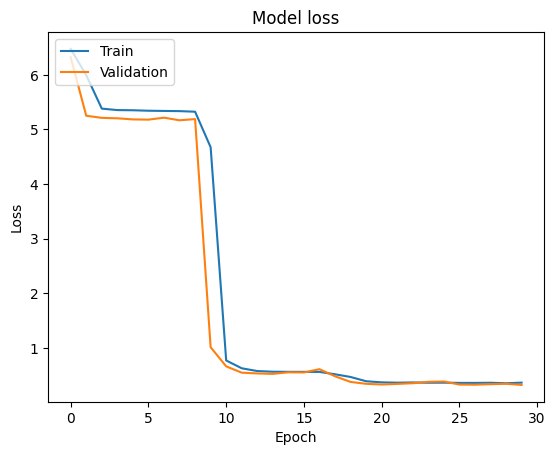

In [ ]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][-50:])
plt.plot(history.history['val_loss'][-50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Test model accuracy on validation set
score_val = model.evaluate(X_val_tensor, y_val_tensor, verbose=0)
print(f"Accuracy (val): {score_val[1]}")

Accuracy (val): 0.8807816505432129


## Regression

In [196]:
# X and y columns
# X_cols = [
#     'Servo Current',
#     'Norm Potentiometer',
#     'Sin Potentiometer',
# ]
X_cols = [
    'Servo Current',
    'Derivative Current',
    'Norm Potentiometer',
    'Derivative Potentiometer',
    # 'Sin Potentiometer',
    # 'Cos Potentiometer',
    # 'Current * Potentiometer',
]
y_cols = ['Stall']

# Convert dataframes to 3D tensors
X_train, y_train = df_to_tensor(df_train_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_val, y_val = df_to_tensor(df_val_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_test, y_test = df_to_tensor(df_test_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)

# Zip data
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))
test_data = list(zip(X_test, y_test))

# Shuffle data
rng.shuffle(train_data)
rng.shuffle(val_data)
rng.shuffle(test_data)

# Unzip data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to tensors
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)
X_val = torch.stack(X_val)
y_val = torch.stack(y_val)
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

# Show shape
print(X_train.shape)

torch.Size([45670, 1, 4])


In [197]:
# Make sure the tensor is correct (not working after shuffle)
# i = 10507
# df_train_windowed.iloc[(i * READINGS_PER_SAMPLE):((i + 1) * READINGS_PER_SAMPLE)]

In [198]:
# print(X_train[i, :, :])
# print(y_train[i])

In [199]:
# Copy data to device (for training)
X_train_tensor = X_train.to(device)
y_train_tensor = y_train.to(device)
X_val_tensor = X_val.to(device)
y_val_tensor = y_val.to(device)

### Model Exploration: Linear Regression (Windowed)

In [200]:
# Flatten the readings for linear regression
X_train_flat =X_train_tensor.view(X_train_tensor.size(0), -1)
y_train_flat = y_train_tensor.view(-1, 1)
X_val_flat = X_val_tensor.view(X_val_tensor.size(0), -1)
y_val_flat = y_val_tensor.view(-1, 1)

# View shape
print(X_train_flat.shape)
print(X_train_flat[i])
print(y_train_flat[i])

torch.Size([45670, 4])
tensor([9.1080e+02, 8.0000e+02, 8.2727e-01, 0.0000e+00], device='cuda:0')
tensor([0.9993], device='cuda:0')


In [201]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
score_train = model.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
print(f"Score (train): {score_train}")
print(model.coef_)
print(model.intercept_)

Score (train): 0.7868079543113708
[[ 7.146673e-04 -5.489638e-06 -3.593523e-08  4.444300e-09]]
[0.02777797]


In [202]:
# Validate model and calculate mean squared error
score = model.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy())
y_val_pred = model.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.8021628856658936
Mean squared error (val): 0.037944767624139786


### Model Exploration: Random Forest (Windowed)

In [203]:
# Train random forest regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=SEED
)
rf.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = rf.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

# Print the size of the model
rf_serialized = pickle.dumps(rf)
print(f"Size of model: {len(rf_serialized) / 1024} kB")

Score (train): 0.9663915942465577
Size of model: 6696.3583984375 kB


In [204]:
# Validate model and calculate mean squared error
score = rf.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = rf.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.9472029378399982
Mean squared error (val): 0.010126371059593001


### Model Exploration: XGBoost (Windowed)

In [211]:
# Train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=15,
    max_depth=5,
    random_state=SEED,
    base_score=0.5
)
xgb.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = xgb.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

# Print the size of the model
xgb_serialized = pickle.dumps(xgb)
print(f"Size of model: {len(xgb_serialized) / 1024} kB")

Score (train): 0.9492360353469849
Size of model: 44.1142578125 kB


In [212]:
# Validate model and calculate mean squared error
score = xgb.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = xgb.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.935290515422821
Mean squared error (val): 0.012411152012646198


### Quantize and Save XGBoost Model

In [216]:
# I <3 this model, so let's save it
model_filename = "xgb_model"

# Create model directory (if it doesn't exist)
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# Save model
xgb.save_model(os.path.join(MODEL_PATH, model_filename + ".json"))

# Convert to C code (change to .cpp for Arduino!)
with open(os.path.join(MODEL_PATH, model_filename + ".c"), "w") as f:
    code = m2c.export_to_c(xgb)
    f.write(code)


In [ ]:
# NOTE: Treelite not seem to be working in C/C++, need to investigate
# Load model into Treelite
# treelite_model = treelite.frontend.load_xgboost_model(
#     os.path.join(MODEL_PATH, model_filename + ".json")
# )

# # Save model to C code (change to .cpp for Arduino!)
# tl2cgen.generate_c_code(
#     treelite_model,
#     dirpath=os.path.join(MODEL_PATH, "treelite_model"),
#     params={
#         "quantize": 1,
#     },
#     verbose=True
# )

[16:43:54] /project/src/compiler/ast/split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.


[16:43:54] /tmp/tmpfk5q71dd/libbuild/_deps/treelite-src/src/serializer.cc:202: The model you are loading originated from a newer Treelite version; some functionalities may be unavailable.
Currently running Treelite version 4.1.2
The model checkpoint was generated from Treelite version 4.4.1


In [217]:
# Get known-good sample
i = 10507
X_sample = X_train[i].view(1, -1).to(device)
y_sample = y_train[i].view(1, 1).to(device)

# Print sample
print(X_sample)

# Perform inference
y_sample_pred = xgb.predict(X_sample.cpu().numpy())
print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

tensor([[  15.4000, -166.6667,    0.9000,    0.0000]], device='cuda:0')
Actual: 0.0, Predicted: 0.01776701956987381


In [218]:
# Do another one (to check for consistency)
i = 30054
X_sample = X_train[i].view(1, -1).to(device)
y_sample = y_train[i].view(1, 1).to(device)

# Print sample
print(X_sample)

# Perform inference
y_sample_pred = xgb.predict(X_sample.cpu().numpy())
print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

tensor([[ 1.3207e+03, -1.4167e+02,  5.3030e-01,  2.5253e-01]], device='cuda:0')
Actual: 0.9788791537284851, Predicted: 0.9639279246330261


### Model Exploration: 1D CNN (Windowed)

In [ ]:
# Create 1D CNN
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Conv1D(64, 2, activation="relu")(inputs)
# x = keras.layers.MaxPooling1D(2, strides=1, padding="same")(x)
x = keras.layers.Conv1D(64, 2, activation="relu")(x)
# x = keras.layers.MaxPooling1D(2, strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Dense(16, activation="relu")(x)
output = keras.layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error")
model.to(device)
print(model.summary())

# Print the size of the model in kilobytes
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024
print(f"Size of model: {model_size} kB")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 64)          │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Size of model: 38.63671875 kB


In [ ]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=20, 
    batch_size=128
)

Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 230294.4844 - val_loss: 40602.7148
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11715.6064 - val_loss: 1152.7533
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2656.0723 - val_loss: 270.4113
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1196.7378 - val_loss: 213.8831
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 712.2158 - val_loss: 115.4362
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 578.4017 - val_loss: 44.6716
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 223.8739 - val_loss: 54.6585
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 155.6527 - val_loss: 26.0740
Epoch 9/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 230.5067 - val_loss: 49.6610
Epoch 10/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 122.8158 - val_loss: 10.8722
Epoch 11/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 63.8141 - val_loss: 7.9592
Epoch 

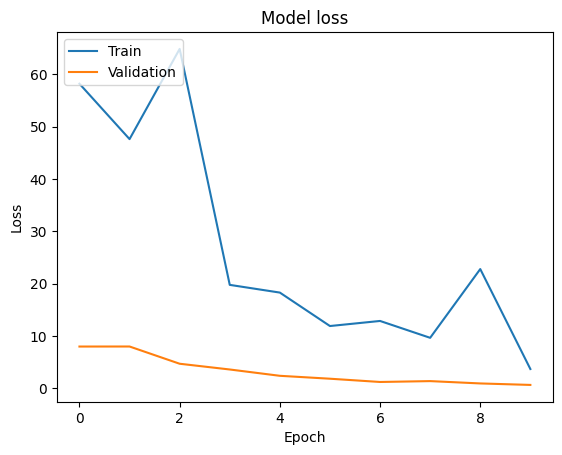

In [ ]:
# Plot loss (ignore first epoch)
first_epoch = 10
plt.plot(history.history['loss'][first_epoch:])
plt.plot(history.history['val_loss'][first_epoch:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Test model score on validation set
score_val = model.evaluate(X_val_tensor, y_val_tensor, verbose=0)
print(f"Mean squared error (val): {score_val}")

Mean squared error (val): 0.6241165995597839


### Model Exploration: DNN (Windowed)

In [207]:
# Create simple neural network
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, activation="relu")(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)
print(model.summary())


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [208]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=20, 
    batch_size=128
)

Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 121112.7266 - val_loss: 2164.6062
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 15218.8799 - val_loss: 36656.2617
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 55890.2383 - val_loss: 4604.9404
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4346.8960 - val_loss: 1542.1855
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2741.9763 - val_loss: 24.2954
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6278.4072 - val_loss: 646.8713
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1947.3113 - val_loss: 926.0924
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3047.8169 - val_loss: 70.9248
Epoch 9/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 804.1683 - val_loss: 344.0233
Epoch 10/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 951.2805 - val_loss: 314.9567
Epoch 11/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3145.3582 - val_loss: 1

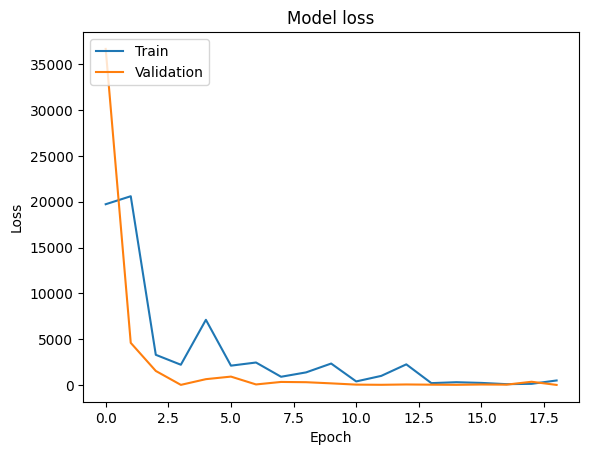

In [209]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [210]:
# Test model score on validation set
score_val = model.evaluate(X_val_tensor, y_val_tensor, verbose=0)
print(f"Mean squared error (val): {score_val}")

Mean squared error (val): 18.799821853637695
